# Sentiment Analysis Model Creation V2.0

## Summary of Previous Exploration and Bottlenecks

In our previous work with a dataset containing only 5 emotion categories, we encountered a significant bottleneck: there simply wasn't enough data to clearly differentiate between similar emotions, particularly **class 3 (anger)** and **class 4 (fear)**. Here are the key issues we faced:

- **Data Scarcity:** The limited examples for anger and fear led to overlap in model predictions, as the subtle nuances between these emotions were not well represented.
- **Oversampling Challenges:** We recognized that oversampling could potentially address the imbalance, but finding or generating additional data for these specific classes proved to be difficult without incurring extra costs.

## Discovery of the GoEmotions Dataset

To overcome these limitations, we turned to the **GoEmotions** dataset, which provides a much richer resource for emotion analysis:

- **Comprehensive Coverage:** GoEmotions includes 58,009 Reddit comments labeled with 27 emotion categories plus a neutral category.
- **Diverse Annotations:** With a broader range of emotions, the dataset captures a wider array of human sentiments, allowing for more precise differentiation between similar emotions.
- **Structured Splits:** The dataset is organized into training, validation, and test splits, making it easier to integrate into our existing pipeline.

This new dataset is a promising solution for improving our emotion detection model, especially in distinguishing nuanced emotions like fear and anger.

Key things:

* we will use a pre-trained word embedding model this time (BERT). Then we'll see whether we need to create our own model, or stick with the existing one. 
* we will keep the data pipeline that we have from the first research for data retrieval and data cleansing.
* we need to handle multi-labeled annotations (description below).



In [4]:
import pandas as pd

df = pd.read_csv('emotion_data/train.tsv', sep='\t', header=None, names=['text', 'labels', 'reddit_id'])
df.head()


,text,labels,reddit_id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [5]:
texts = df['text'].tolist()

labels = [label_str.split(',') for label_str in df['labels'].tolist()]


reddit_ids = df['reddit_id'].tolist()


print(f"Loaded {len(texts)} texts, {len(labels)} label sets, and {len(reddit_ids)} reddit IDs.")
print(texts[:2])
print(labels[:2])

Loaded 43410 texts, 43410 label sets, and 43410 reddit IDs.
["My favourite food is anything I didn't have to cook myself.", 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead']
[['27'], ['27']]


Perfect, now let's use the data processing to convert our list of text into a list of tokens

In [6]:
import re
import spacy
from bs4 import BeautifulSoup
from spacy.tokens import Token



patterns = {
    r"\bim\b": "I'm",
    r"\byoure\b": "you're",
    r"\bdidnt\b": "didn't",
    r"\bdont\b": "don't",
    r"\bcan't\b": "can't",  # Already correct if typed correctly, but you can handle "cant"
    r"\bcant\b": "can't",
    r"\bwont\b": "won't",
    r"\bwouldnt\b": "wouldn't",
    r"\bshouldnt\b": "shouldn't",
    r"\bcouldnt\b": "couldn't",
    r"\bmustnt\b": "mustn't",
    r"\bwasnt\b": "wasn't",
    r"\bwerent\b": "weren't",
    r"\bhavent\b": "haven't",
    r"\bhasnt\b": "hasn't",
    r"\bill\b": "I'll",
    r"\bhes\b": "he's",
    r"\bshes\b": "she's",
    r"\bits\b": "it's",      # Use context to decide if it's possessive or a contraction
    r"\bthats\b": "that's",
    r"\bwhos\b": "who's",
    r"\bhows\b": "how's",
    r"\bwheres\b": "where's",
    r"\btheres\b": "there's",
    r"\byoure\b": "you're",
    r"\bwouldve\b": "would've",
    r"\bshouldve\b": "should've",
    r"\bcouldve\b": "could've",
    r"\bmightve\b": "might've",
    r"\bmustve\b": "must've",
    r"\bneednt\b": "needn't",
    r"\bshant\b": "shan't",
    r"\byall\b": "y'all"
}
# Define a set of sentiment-bearing words (normalized to lowercase)
sentiment_lemmas = {"not", "no", "nor", "very", "extremely", "really", "so", "too", "just", "but"}
# Load your spaCy model
nlp = spacy.load("en_core_web_sm")
Token.set_extension("is_sentiment", default=False, force=True)

tokenized_texts_test = []
for text in texts:

    # Use BeautifulSoup to parse the text and remove unwanted tags
    soup = BeautifulSoup(text, "html.parser")
    for tag in soup(["script", "style"]):
        tag.decompose()  # Remove script and style elements completely

    # Extract text and remove extra whitespace/newlines
    text = soup.get_text(separator=" ")
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)

    # Process the cleaned text with spaCy
    doc = nlp(text)

    # Mark tokens as sentiment-bearing based on their lemma
    for token in doc:
        if token.lemma_.lower() in sentiment_lemmas:
            token._.is_sentiment = True

    cleaned_tokens = []


    for token in doc:
        # Skip punctuation and numbers
        if token.is_punct or token.like_num:
            continue
        # Skip stop words UNLESS they are marked as sentiment-bearing.
        if token.is_stop and not token._.is_sentiment:
            continue
        lemma = token.lemma_.lower().strip()
        if lemma and lemma != '-pron-':
            cleaned_tokens.append(lemma)
    tokenized_texts_test.append(cleaned_tokens)

print(tokenized_texts_test[:2])



[['favourite', 'food', 'not', 'cook'], ['think', 'have', 'laugh', 'screw', 'people', 'instead', 'actually', 'dead']]


## Word Embeddings using BERT

In this cell, we load a pre-trained BERT model ("bert-base-uncased") from Hugging Face to generate sentence embeddings. The [CLS] token embedding is used as the sentence representation for each input text.

You can download the model and tokenizer here: [bert-base-uncased](https://huggingface.co/bert-base-uncased).

The provided function `get_sentence_embeddings` tokenizes the text, passes it through BERT, and extracts the [CLS] embeddings.



In [7]:
from transformers import AutoTokenizer, AutoModel
import torch

# Define the pre-trained BERT model name (BERT-base, uncased)
model_name = "bert-base-uncased"
# Download the pre-trained model and tokenizer from Hugging Face:
# https://huggingface.co/bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_sentence_embeddings(text_list, max_length=128):
    """
    Given a list of text strings, this function returns the sentence embeddings using BERT.
    It uses the embedding of the [CLS] token as the sentence representation.
    """
    # Tokenize the input texts
    encoded_inputs = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    # Obtain the BERT embeddings without gradient computation
    with torch.no_grad():
        outputs = model(**encoded_inputs)
    
    # The [CLS] token embedding (first token) is used as the sentence embedding
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings

# Example usage:
sample_texts = [
    "This is an example sentence.",
    "BERT embeddings are powerful for many NLP tasks."
]
embeddings = get_sentence_embeddings(sample_texts)
print("Shape of embeddings:", embeddings.shape)


Shape of embeddings: torch.Size([2, 768])


1. **Import Libraries:**  
   We start by importing the necessary modules from the `transformers` library (`AutoTokenizer` and `AutoModel`) and PyTorch. These are essential for loading and using the pre-trained BERT model.

2. **Define the Pre-trained Model:**  
   We choose the `bert-base-uncased` model—a popular version of BERT. You can download it from [bert-base-uncased](https://huggingface.co/bert-base-uncased). This model has been pre-trained on a large corpus and works well for many NLP tasks.

3. **Load Tokenizer and Model:**  
   Using `AutoTokenizer.from_pretrained(model_name)` and `AutoModel.from_pretrained(model_name)`, the code downloads the tokenizer and model. This step fetches all the necessary weights and configuration files from Hugging Face.

4. **Tokenization and Embedding Function:**  
   The function `get_sentence_embeddings` does the following:
   - **Tokenizes Input Texts:**  
     It converts a list of text strings into tokens, ensuring each input is padded and truncated to a consistent `max_length`.
   - **Model Inference:**  
     The tokens are passed through the BERT model to generate embeddings. We wrap this in a `torch.no_grad()` block to disable gradient calculation since we're only performing inference.
   - **Extract [CLS] Embeddings:**  
     BERT’s [CLS] token (the first token) is used as the representation for the entire sentence. This embedding is extracted from the model’s output.


## Applying BERT Embeddings to Test Data

Now that we have our function to generate BERT sentence embeddings, we apply it to our list of tokenized test texts (`tokenized_texts_test`). This will produce a tensor containing the [CLS] embeddings for each test example.


In [8]:
# Apply the BERT embedding function to the tokenized test texts
test_embeddings = get_sentence_embeddings(tokenized_texts_test)

# Print the shape of the resulting embeddings to verify the output
print("Shape of test embeddings:", test_embeddings.shape)


TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

## Converting Tokenized Data Back to Raw Text

For sentiment analysis, the BERT tokenizer expects raw text strings rather than pre-tokenized input. Since your `tokenized_texts_test` variable contains tokenized data, the best approach is to join the tokens back into full sentences before generating embeddings.

Below, we join the tokens for each example into a string and then pass the resulting list of raw texts to the `get_sentence_embeddings` function.


Oops, seems like we couldn't run this cell due to memory overload. 

## Handling Memory Issues with Large Datasets

When working with large datasets, processing all texts at once can easily exceed available memory. Instead of feeding the entire list into BERT in one go, it's best to process the texts in smaller batches. This way, you reduce the memory load and avoid out-of-memory errors.

In [9]:
raw_texts_test = [' '.join(tokens) for tokens in tokenized_texts_test]


batch_size = 32  # You can adjust the batch size based on your memory constraints
embeddings_list = []

for i in range(0, len(raw_texts_test), batch_size):
    batch_texts = raw_texts_test[i:i+batch_size]
    batch_embeddings = get_sentence_embeddings(batch_texts)
    embeddings_list.append(batch_embeddings)
    print(f"Processed batch {i // batch_size + 1}/{(len(raw_texts_test) + batch_size - 1) // batch_size}")

# Concatenate all batch embeddings into one tensor
test_embeddings = torch.cat(embeddings_list, dim=0)

# Print the shape of the resulting embeddings to verify the output
print("Shape of test embeddings:", test_embeddings.shape)

Processed batch 1/1357
Processed batch 2/1357
Processed batch 3/1357
Processed batch 4/1357
Processed batch 5/1357
Processed batch 6/1357
Processed batch 7/1357
Processed batch 8/1357
Processed batch 9/1357
Processed batch 10/1357
Processed batch 11/1357
Processed batch 12/1357
Processed batch 13/1357
Processed batch 14/1357
Processed batch 15/1357
Processed batch 16/1357
Processed batch 17/1357
Processed batch 18/1357
Processed batch 19/1357
Processed batch 20/1357
Processed batch 21/1357
Processed batch 22/1357
Processed batch 23/1357
Processed batch 24/1357
Processed batch 25/1357
Processed batch 26/1357
Processed batch 27/1357
Processed batch 28/1357
Processed batch 29/1357
Processed batch 30/1357
Processed batch 31/1357
Processed batch 32/1357
Processed batch 33/1357
Processed batch 34/1357
Processed batch 35/1357
Processed batch 36/1357
Processed batch 37/1357
Processed batch 38/1357
Processed batch 39/1357
Processed batch 40/1357
Processed batch 41/1357
Processed batch 42/1357
P

## Multi-Label Emotion Classification Using BERT Embeddings

In this updated pipeline we no longer use Word2Vec. Instead, we use BERT to generate sentence embeddings (using the [CLS] token) for each text. We then build a multi-label classifier on top of these fixed BERT embeddings. The steps are as follows:

1. **Data Preparation:**  
   - Convert your tokenized texts back into raw strings.  
   - Convert the label information into multi-hot vectors for 28 classes (27 emotions + neutral).

2. **Embedding Computation:**  
   - Compute BERT embeddings in manageable batches to avoid memory issues.
   - This yields a fixed 768-dimensional vector for each text.

3. **Model Building:**  
   - A simple feed-forward neural network is built with Dense and Dropout layers.
   - The output layer has 28 sigmoid-activated neurons for multi-label prediction.
   - We use binary cross-entropy loss for training.

Below is the complete code for this updated pipeline.

Computing BERT embeddings for training data...
Processed batch 1/1086
Processed batch 2/1086
Processed batch 3/1086
Processed batch 4/1086
Processed batch 5/1086
Processed batch 6/1086
Processed batch 7/1086
Processed batch 8/1086
Processed batch 9/1086
Processed batch 10/1086
Processed batch 11/1086
Processed batch 12/1086
Processed batch 13/1086
Processed batch 14/1086
Processed batch 15/1086
Processed batch 16/1086
Processed batch 17/1086
Processed batch 18/1086
Processed batch 19/1086
Processed batch 20/1086
Processed batch 21/1086
Processed batch 22/1086
Processed batch 23/1086
Processed batch 24/1086
Processed batch 25/1086
Processed batch 26/1086
Processed batch 27/1086
Processed batch 28/1086
Processed batch 29/1086
Processed batch 30/1086
Processed batch 31/1086
Processed batch 32/1086
Processed batch 33/1086
Processed batch 34/1086
Processed batch 35/1086
Processed batch 36/1086
Processed batch 37/1086
Processed batch 38/1086
Processed batch 39/1086
Processed batch 40/1086
Pr

/Users/daniyalkhaibullin/Documents/projects/sentiment_analysis/sent_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,372 (911.61 KB)

 Trainable params: 233,372 (911.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2562 - loss: 0.1888 - val_accuracy: 0.3645 - val_loss: 0.1288
Epoch 2/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3688 - loss: 0.1367 - val_accuracy: 0.4006 - val_loss: 0.1226
Epoch 3/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3900 - loss: 0.1304 - val_accuracy: 0.4145 - val_loss: 0.1206
Epoch 4/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4054 - loss: 0.1260 - val_accuracy: 0.4250 - val_loss: 0.1194
Epoch 5/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4049 - loss: 0.1249 - val_accuracy: 0.4249 - val_loss: 0.1190
Epoch 6/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4112 - loss: 0.1236 - val_accuracy: 0.4299 - val_loss: 0.1181
Epoch 7/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4190 - loss: 0.1235 - val_accuracy: 0.4381 - val_loss: 0.1168
Epoch 8/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4178 - loss: 0.1219 - 

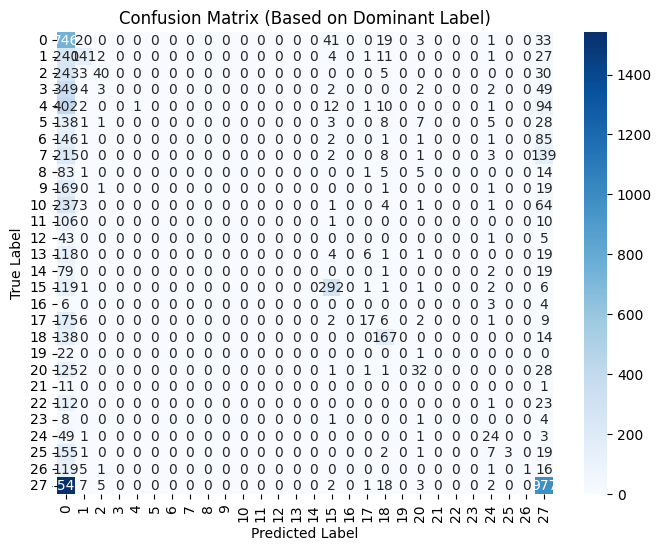

In [15]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 0. Load BERT Tokenizer and Model ---
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"
# Use distinct variable names for BERT components to avoid conflicts with Keras tokenizer.
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

def get_sentence_embeddings(text_list, max_length=128):
    """
    Given a list of raw text strings, return BERT embeddings using the [CLS] token.
    """
    encoded_inputs = bert_tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = bert_model(**encoded_inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings

# --- 1. Data Preparation ---
# Use tokenized_texts_test as provided.
# Convert tokenized texts back to raw text strings.
raw_texts = [" ".join(tokens) for tokens in tokenized_texts_test]

# Convert label information to multi-hot vectors.
num_classes = 28  # 27 emotions + neutral
multi_hot_labels = []
for label_val in labels:
    multi_hot = np.zeros(num_classes, dtype=int)
    if isinstance(label_val, list):
        label_items = label_val
    else:
        label_items = label_val.split(',')
    for l in label_items:
        l = str(l).strip()
        if l != "":
            idx = int(l)
            multi_hot[idx] = 1
    multi_hot_labels.append(multi_hot)
y = np.array(multi_hot_labels)

# Split data into training and validation sets.
raw_texts_train, raw_texts_val, y_train, y_val = train_test_split(raw_texts, y, test_size=0.2, random_state=42)

# --- 2. Compute BERT Embeddings ---
def compute_embeddings(texts, batch_size=32):
    embeddings_list = []
    total_batches = (len(texts) + batch_size - 1) // batch_size
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = get_sentence_embeddings(batch_texts)  # returns tensor of shape [batch_size, 768]
        embeddings_list.append(batch_embeddings)
        print(f"Processed batch {i // batch_size + 1}/{total_batches}")
    # Concatenate all batches and convert to numpy array for Keras.
    return torch.cat(embeddings_list, dim=0).numpy()

print("Computing BERT embeddings for training data...")
X_train_embeddings = compute_embeddings(raw_texts_train)
print("Computing BERT embeddings for validation data...")
X_val_embeddings = compute_embeddings(raw_texts_val)

print("Training embeddings shape:", X_train_embeddings.shape)
print("Validation embeddings shape:", X_val_embeddings.shape)

# --- 3. Build the Multi-Label Classifier Model ---
# With fixed 768-dim BERT embeddings, we build a simple feed-forward network.
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(768,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))  # Sigmoid activation for multi-label classification

model.summary()

# --- 4. Compile and Train the Model ---
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train_embeddings, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val_embeddings, y_val))

# --- 5. Evaluate the Model ---
val_loss, val_accuracy = model.evaluate(X_val_embeddings, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Generate predictions and apply a threshold of 0.5.
y_pred = model.predict(X_val_embeddings)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print the classification report.
print(classification_report(y_val, y_pred_binary, zero_division=0))

# Visualize the confusion matrix based on the dominant (highest probability) label.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred_binary.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Based on Dominant Label)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()